In [98]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate

In [99]:
# Load testing dataset(Daily data)
def read_daily_test_df(features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    #Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

# Train and cross-validate the model
def training_cv(df,features,nutrient,year,loss_func):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    features.append(nutrient)
    df = df[df['YY'].isin(year)][features].dropna()
    X_train = df.iloc[:,:-1]
    y_train = df.iloc[:,-1].values
    print('Number of samples: ' + str(len(y_train)))

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    GBR.set_params(**GBR_rs.best_params_,random_state=101,loss=loss_func).fit(X_train,y_train)
    mae= -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_absolute_error')
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("MAE %.2f (+/- %.2f)" % (mae.mean(), mae.std()))
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))
    features.pop() 
    
# Make prediction with trained model
def predict(Erken_Nut,df,features,nutrient,test_time,ylim,Lake_Nut_metrics):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_Nut[nutrient]=GBR.predict(Erken_Nut[features])
    #Erken_Nut[nutrient]=Erken_Nut[nutrient].rolling(7,min_periods = 1,center=True).mean()
    nutrient_compare = Erken_Nut[['Date',nutrient]].merge(df[['Date',nutrient]].dropna(),
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                      end = test_time[1]),
                    columns = ['Date'])
    #Erken_Nut_gap = Date.merge(Erken_Nut,how = 'left',on = 'Date')
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>=test_time[0])&(nutrient_compare['Date']<=test_time[1])]
    Lake_Nut_metrics[nutrient]['MAE']=mean_absolute_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'])
    Lake_Nut_metrics[nutrient]['RMSE']=mean_squared_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'],
                                                          squared = False)    
    Lake_Nut_metrics[nutrient]['R2']=r2_score(nutrient_compare['True'],
                                              nutrient_compare['Prediction'])
    return Erken_Nut[['Date',nutrient]],Lake_Nut_metrics

In [101]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter5.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Scenario2\GBR
Load training data (containing nutrient observations)
Lake name in short: Fureso
Winter data or not? (Y/N)Y


In [6]:
## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{},in total {} years'.format(year,len(year)))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2017 2019
 2016 2018],in total 30 years
Number of years for training:20
Training year:1990
Training year:1991
Training year:1992
Training year:1993
Training year:1994
Training year:1995
Training year:1996
Training year:1997
Training year:1998
Training year:1999
Training year:2000
Training year:2001
Training year:2002
Training year:2003
Training year:2004
Training year:2005
Training year:2006
Training year:2007
Training year:2008
Training year:2009


In [102]:
print(all_df.info())
n_feature = int(input('Number of daily features used for training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10609 entries, 0 to 10608
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10609 non-null  datetime64[ns]
 1   Chl        483 non-null    float64       
 2   NOX        500 non-null    float64       
 3   DO_sur     495 non-null    float64       
 4   DO_bot     450 non-null    float64       
 5   PO4        499 non-null    float64       
 6   NH4        518 non-null    float64       
 7   TotP       499 non-null    float64       
 8   TotN       500 non-null    float64       
 9   inflow     10590 non-null  float64       
 10  thermD     10590 non-null  float64       
 11  delT       10590 non-null  float64       
 12  U          10590 non-null  float64       
 13  AirP       10590 non-null  float64       
 14  AirT       10590 non-null  float64       
 15  Hum        10590 non-null  float64       
 16  CC         10590 non-null  float64      

In [103]:
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),
             pd.Timestamp(int(input('test ends in year:')),12,31)]

test starts in year:2010
test ends in year:2018


In [104]:
Nut_num = int(input('How many nutrients to predict? (include Chl and put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))

How many nutrients to predict? (include Chl and put them in order) 8
Nut_1: NOX
Nut_2: DO_sur
Nut_3: DO_bot
Nut_4: PO4
Nut_5: TotP
Nut_6: TotN
Nut_7: NH4
Nut_8: Chl


In [30]:
features.insert(0,'Date')

In [53]:
features.pop()

'NOX'

In [105]:
Lake_Nut_metrics = pd.DataFrame(columns = Nut,index=['MAE','RMSE','R2'])
Lake_Nut=pd.DataFrame(columns = ['Date'])

In [106]:
os.chdir(cd+'\\Trainning data')
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'

testing_daily_df = read_daily_test_df(features,file) 

loss_func='huber'
features.pop(0)
start_time = time.time()
for j in range(Nut_num): 
    if j!=0:
        features.append(Nut[j-1]) 
    nutrient=Nut[j]
    print(nutrient)    
    if j==0:
        model = training_cv(all_df,features,nutrient,training_yr,loss_func)
    else:
        model = training_cv(testing_daily_df.merge(all_df[['Date']+[nutrient]],on='Date',how='outer')
                            ,features,nutrient,training_yr,loss_func)
    ylim = (0,all_df[Nut[j]].max())
    Model,Lake_Nut_metrics = predict(testing_daily_df,all_df,
                                          features,nutrient,test_time,
                                          ylim,Lake_Nut_metrics)
    Lake_Nut =Lake_Nut.merge(Model,on=['Date'],how='outer')
    print('\n')

print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
#Erken_Nut = testing_daily_df.merge(NOX_Model,on = 'Date',how = 'left')

NOX
Number of samples: 367
Training dataset evaluation:
MAE 0.10 (+/- 0.02)
RMSE 0.14 (+/- 0.03)
R2 0.40 (+/- 0.10)


DO_sur
Number of samples: 362
Training dataset evaluation:
MAE 1.37 (+/- 0.17)
RMSE 1.84 (+/- 0.21)
R2 0.38 (+/- 0.09)


DO_bot
Number of samples: 332
Training dataset evaluation:
MAE 1.87 (+/- 0.31)
RMSE 2.51 (+/- 0.43)
R2 0.59 (+/- 0.16)


PO4
Number of samples: 366
Training dataset evaluation:
MAE 0.08 (+/- 0.05)
RMSE 0.10 (+/- 0.05)
R2 -1.41 (+/- 1.17)


TotP
Number of samples: 366
Training dataset evaluation:
MAE 0.04 (+/- 0.03)
RMSE 0.05 (+/- 0.03)
R2 -0.33 (+/- 0.80)


TotN
Number of samples: 367
Training dataset evaluation:
MAE 0.14 (+/- 0.03)
RMSE 0.19 (+/- 0.03)
R2 0.10 (+/- 0.05)


NH4
Number of samples: 366
Training dataset evaluation:
MAE 0.02 (+/- 0.00)
RMSE 0.05 (+/- 0.01)
R2 -0.01 (+/- 0.05)


Chl
Number of samples: 350
Training dataset evaluation:
MAE 14.31 (+/- 6.05)
RMSE 26.31 (+/- 17.03)
R2 0.20 (+/- 0.11)


Model takes 10 min to run


In [107]:
Lake_Nut_metrics

,NOX,DO_sur,DO_bot,PO4,TotP,TotN,NH4,Chl
MAE,0.056037,1.057149,1.605646,0.028824,0.017242,0.118699,0.010963,7.975084
RMSE,0.070203,1.432424,2.088064,0.035421,0.022017,0.141275,0.016731,11.744235
R2,0.685859,0.569267,0.594162,-0.073488,0.533553,-0.089001,-0.062878,0.051331


In [108]:
os.chdir(cd+'\\Scenario2\\GBR')
Lake_Nut[(Lake_Nut['Date']>=test_time[0])&(Lake_Nut['Date']<=test_time[1])].to_csv(lakename+'_GBR predicted nutrient and Chl.csv',index = False)
Lake_Nut_metrics.to_csv(lakename+'_GBR_metrics.csv',index=False)

In [109]:
OB['YY']=OB['Date'].apply(lambda d:d.year)
yy=OB[(OB['Date']>=test_time[0])&(OB['Date']<test_time[1])]['YY'].unique()
sam_int=[]
for i in range(len(yy)):
    sam_int.append(OB[OB['YY']==yy[i]]['Date'].diff().mean().days)
print('Averaged sample interval: {}'.format(round(np.nanmean(sam_int))))

Averaged sample interval: 18


Threshold of delta_Chl:0.6
Threshold of Chl:10
Name of Chl variable: Chl


C:\Users\shuli278\AppData\Local\Temp/ipykernel_22244/3652000594.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OB_bloom['YY']=OB_bloom['Date'].apply(lambda d:d.year)


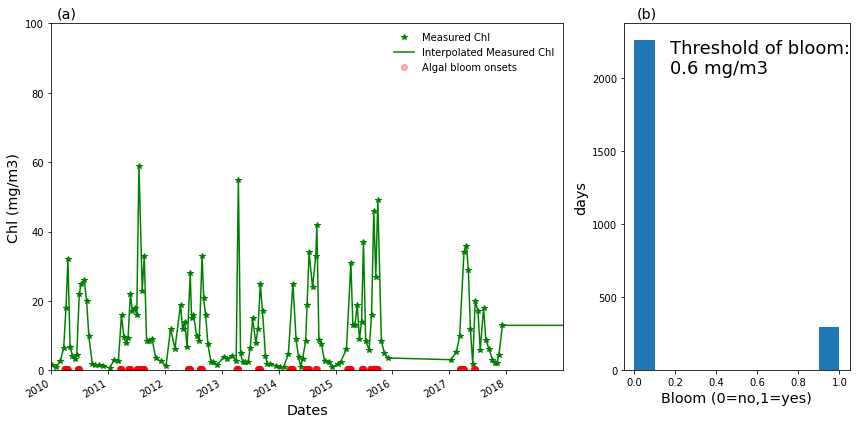

In [111]:
# Use the delta_Chl threshold to find the onset dates of algal bloom
threshold1 = float(input('Threshold of delta_Chl:'))
threshold2 = float(input('Threshold of Chl:'))
def find_bloom(x):
    if (x['delta_Chl']>threshold1)&(x[Chl_name]>threshold2):
        return 1
    else:
        return 0

Chl_name=input('Name of Chl variable: ')
OB=all_df[['Date',Chl_name]].dropna()
OB=OB[~OB['Date'].duplicated()]
OB_int = OB.set_index('Date').reindex(pd.date_range(start = test_time[0],end = test_time[1],freq = '1D')).interpolate(method = 'linear')
OB_int = OB_int.reset_index()
OB_int.columns = ['Date','Chl']
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
# Use the delta_Chl threshold to find the onset dates of algal bloom
OB_int['delta_Chl'] = np.diff(OB_int['Chl'],append=0)
OB_int['Bloom'] = OB_int.apply(lambda x: find_bloom(x), axis=1) 
OB_bloom = OB_int[['Date','Bloom']]
OB_bloom['YY']=OB_bloom['Date'].apply(lambda d:d.year)
OB_bloom=OB_bloom[OB_bloom['YY'].isin(yy)][['Date','Bloom']]

fig=plt.figure(tight_layout='pad',figsize = (12,6))

gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
OB_bloom['Bloom'].hist(grid=False,ax=ax2)
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ax1.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'ro',alpha=0.3,label='Algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Chl (mg/m3)')
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_ylim(0,100)
ax1.set_title('(a)',x=0.03)
ax2.set_xlabel('Bloom (0=no,1=yes)')
ax2.set_ylabel('days')
ax2.set_title('(b)',x=0.1)
fig.text(0.78,0.9,'Threshold of bloom: \n'+str(threshold1)+' mg/m3',fontsize=18,
         horizontalalignment='left',
         verticalalignment='top')
plt.rcParams.update({'axes.titlesize': 'x-large','axes.labelsize': 'x-large'})
fig.savefig(lakename+'_Chl observation and bloom dates.png',dpi=300)

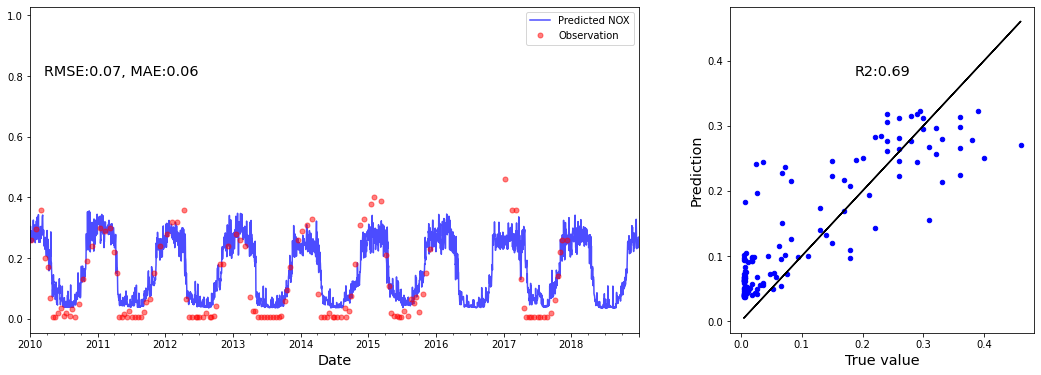

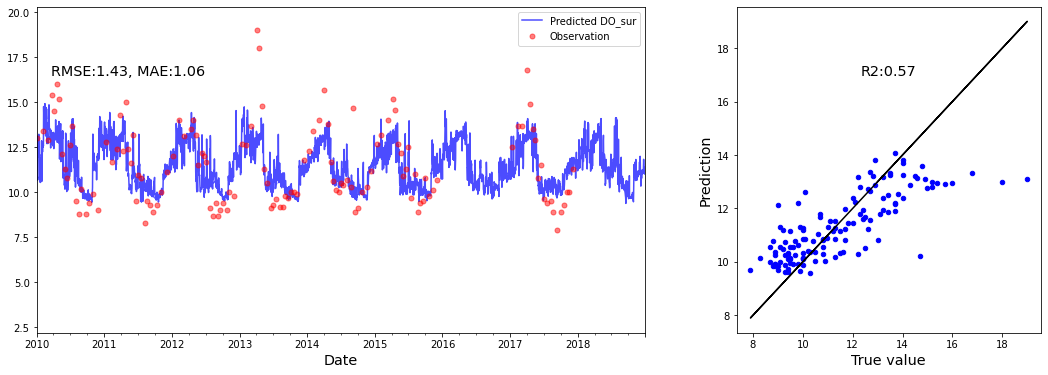

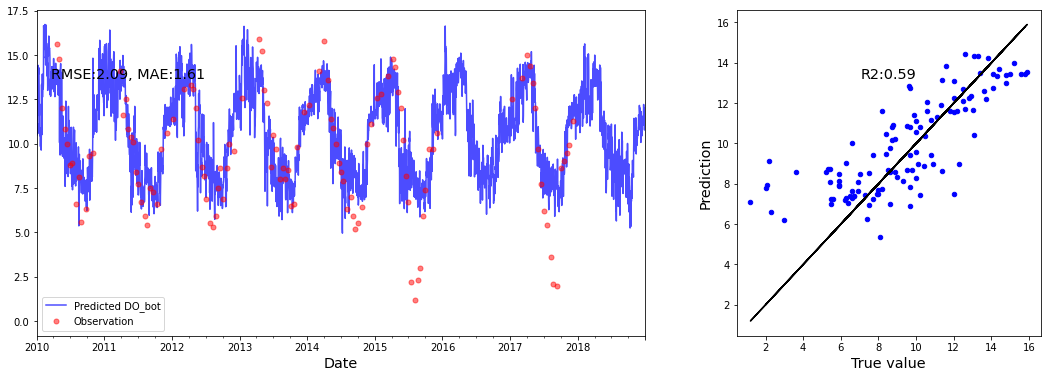

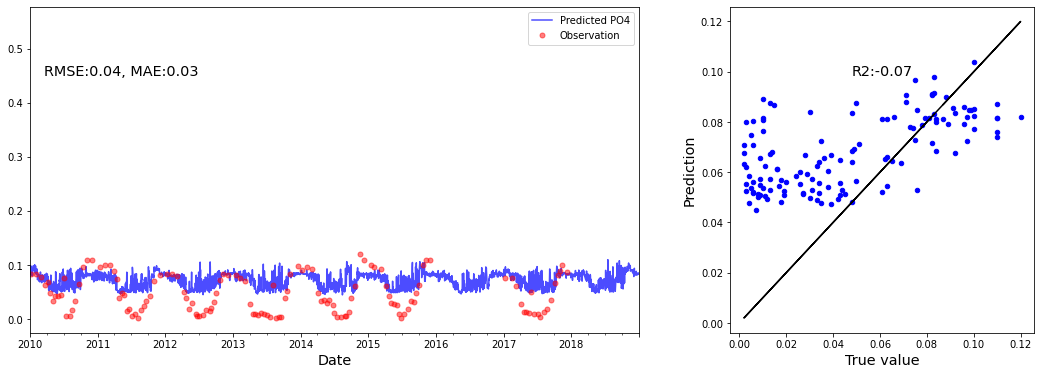

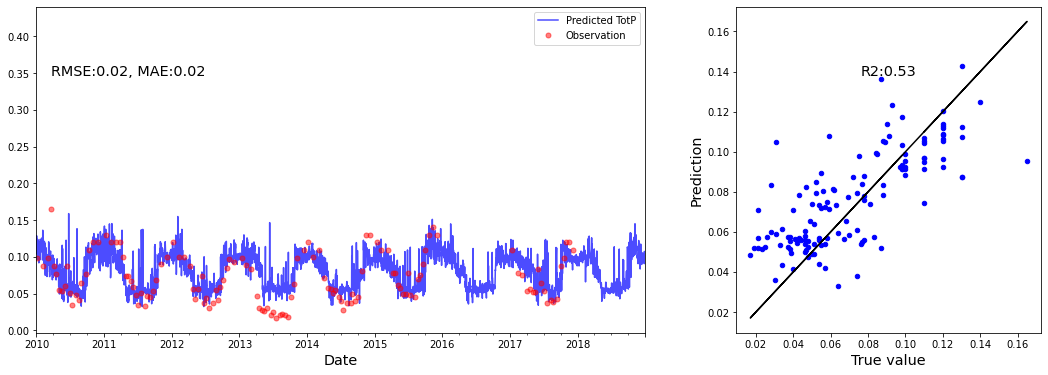

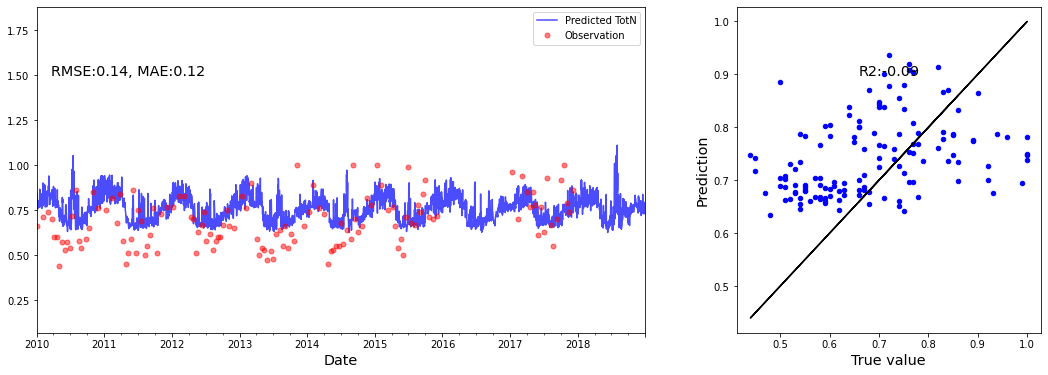

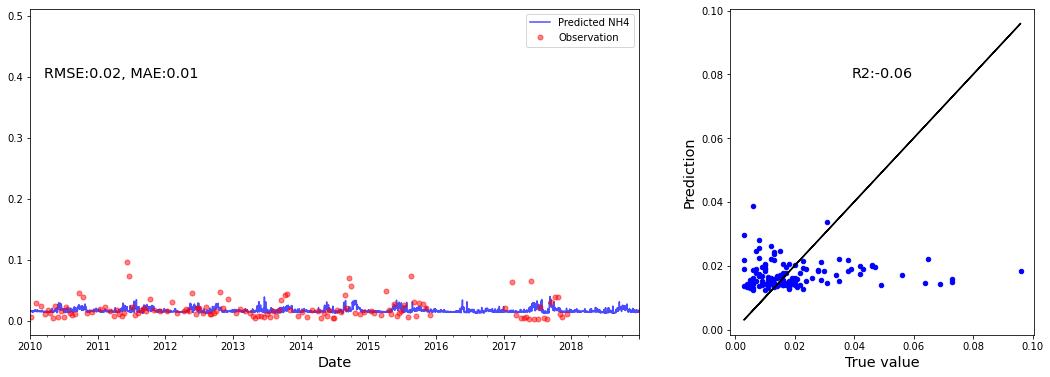

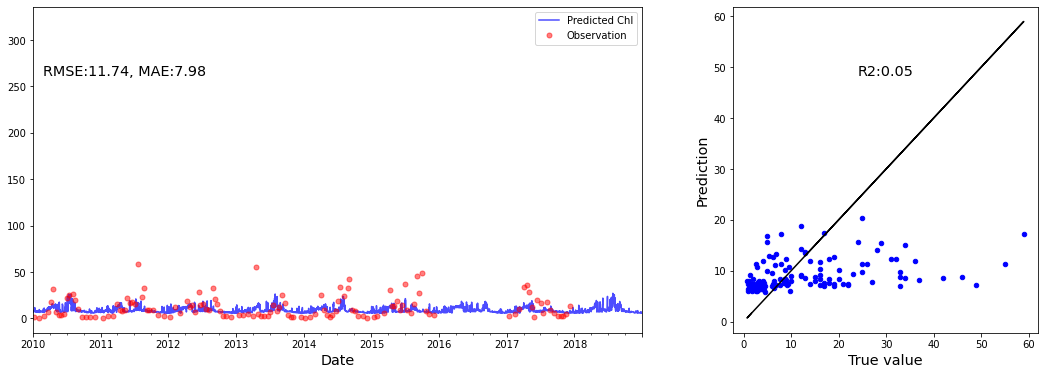

In [112]:
#os.chdir(cd+'\\Work record\\2-Pre-generated nutrients scenario\\GBR')
for k in range(Nut_num):
    nutrient_compare = Lake_Nut[['Date',Nut[k]]].merge(all_df[['Date',Nut[k]]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']<test_time[1])&(nutrient_compare['Date']>test_time[0])]
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
 
    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared=False)
    MAE = mean_absolute_error(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot time-series comparison
    f1,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'b',ax = ax2[0],alpha=0.7,label = 'Predicted '+Nut[k])
    #Lake_Nut_gap[Nut[k]] = Lake_Nut_gap[Nut[k]].rolling(7,min_periods = 1).mean()
    #Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'k',ax = ax2[0],alpha=0.7,
    #                  label = 'Predicted 7d-averaged '+Nut[k])
    all_df[['Date',Nut[k]]].plot(x = 'Date',y =Nut[k],style = 'ro',ms = 5,alpha = 0.5,ax = ax2[0],
                       label = 'Observation')

    ax2[0].text(0.15, 0.8, 'RMSE:{}, MAE:{}'.format(round(RMSE,2),round(MAE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')

    ax2[0].set_xlim((test_time[0],test_time[1]))
    #ax2[0].set_ylim(Lake_Nut[Nut[k]].min(),Lake_Nut[Nut[k]].max())

    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    f1.savefig(lakename+'_GBR_'+Nut[k]+'.png',dpi = 500)

In [115]:
sample_interval=int(input('Sample interval: ')) # 7
rolling_interval=int(input('Rolling interval: '))
rolling_threshold=float(input('Rolling bloom threshold: '))

def compute_metrics(Event_detection,OB_column,model_column):
    tn, fp, fn, tp=confusion_matrix(Event_detection[OB_column],Event_detection[model_column]).ravel() 
    TPR=tp/(tp+fn)
    FPR=fp/(fp+tn)
    accuracy=(tn+tp)/(tn+tp+fn+fp)
    precision=tp/(tp+fp)
    prevalence=(fn+tp)/(tn+tp+fn+fp)
    f1=tp/(tp+0.5*(fp+fn))
    pe=((tp+fp)/(tn+tp+fn+fp)*(fn+tn)/(tn+tp+fn+fp))+((tp+fn)/(tn+tp+fn+fp)*(fp+tn)/(tn+tp+fn+fp))
    kappa=(accuracy-pe)/(1-pe)
    return TPR,FPR,accuracy,precision,prevalence,f1,pe,kappa


ML_Chl = Lake_Nut[['Date',Chl_name]]
ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
ts=pd.DataFrame(pd.date_range(start=ML_Chl['Date'].iloc[0],
                              end=ML_Chl['Date'].iloc[-1],
                              freq='D'),
                columns=['Date'])
ML_Chl=ts.merge(ML_Chl,on='Date',how='left')
ML_Chl['delta_Chl'] = np.diff(ML_Chl[Chl_name],append = 0)

ML_Chl['Bloom'] = ML_Chl.apply(lambda x: find_bloom(x),axis=1)
ML_bloom = ML_Chl[['Date','Bloom']]
ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,
                                                      center=False,
                                                      closed='both').mean().apply(lambda x: 1 if x>=rolling_threshold else 0)
# Find the model hits the events or not
Event_detection = OB_bloom.merge(ML_bloom[['Date','rolling_bloom']],how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','ML']

TPR,FPR,accuracy,precision,prevalence,f1,pe,kappa=compute_metrics(Event_detection,'OB','ML')

print('GBR model')
print('TPR: {},\nFPR: {}, \naccuracy: {}, \nprecision: {}, \nprevalence: {},\nf1: {}, \nkappa:{}.'.format(round(TPR,2),
                                                                                                          round(FPR,2),
                                                                                                          round(accuracy,2),
                                                                                                          round(precision,2),
                                                                                                          round(prevalence,2),
                                                                                                          round(f1,2),
                                                                                                          round(kappa,2)))

Metrics=pd.DataFrame({'TPR':[TPR],'FPR':[FPR],'Accuracy': [accuracy],'Precision':[precision],
             'prevalence':[prevalence],'F1':[f1],'Kappa':[kappa]},index=['ML'])

Sample interval: 10
Rolling interval: 3
Rolling bloom threshold: 0.01
GBR model
TPR: 0.02,
FPR: 0.05, 
accuracy: 0.84, 
precision: 0.05, 
prevalence: 0.12,
f1: 0.03, 
kappa:0.82.


C:\Users\shuli278\AppData\Local\Temp/ipykernel_22244/624570281.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
C:\Users\shuli278\AppData\Local\Temp/ipykernel_22244/624570281.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,


Text(0, 0.5, '(%)')

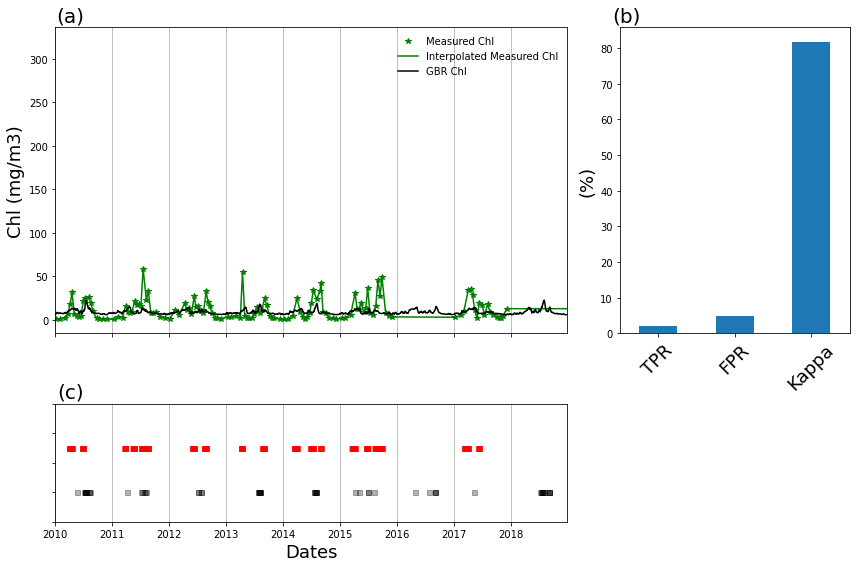

In [116]:
fig=plt.figure(tight_layout='True',figsize = (12,8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0:2, :-1])
ax2 = fig.add_subplot(gs[2, :-1])

ax3 = fig.add_subplot(gs[0:2, -1])

OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ML_Chl.plot(x = 'Date',y = Chl_name,style = 'k',ax=ax1,label='GBR Chl')
ax2.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'rs',alpha=0.3,markersize=5,
         label='Observed algal bloom onsets')
ax2.plot(ML_bloom[ML_bloom['Bloom']==1]['Date'],
         ML_bloom[ML_bloom['Bloom']==1]['Bloom']*0.5-0.3,'ks',alpha=0.3,markersize=5,
         label='Predicted algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel(' ')
ax1.set_xticklabels([])
ax1.set_ylabel('Chl (mg/m3)',fontsize=18)
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_title('(a)',x=0.03,fontsize=20)
ax2.set_xlim(test_time[0],test_time[1])
ax2.set_ylabel(' ')
ax2.set_ylim(0,0.8)
ax2.set_yticklabels([])
ax2.set_xlabel('Dates',fontsize=18)
ax2.set_title('(c)',x=0.03,fontsize=20)
ax1.grid(axis='x')
ax2.grid(axis='x')

(Metrics[['TPR','FPR','Kappa']]*100).T.plot(kind='bar',ax=ax3)
ax3.legend('',frameon=False)
ax3.set_xticklabels(['TPR','FPR','Kappa'],rotation=45,fontsize=18)
ax3.set_title('(b)',x=0.03,fontsize=20)
ax3.set_ylabel('(%)',fontsize=18)

In [94]:
fig.savefig(lakename+'_GBR_Chl_bloom time.png',dpi = 500)

In [95]:
os.getcwd()

'C:\\Users\\shuli278\\Documents\\D\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning\\Algal-bloom-prediction-machine-learning\\Trainning data'